# Recommendation Systems

This notebook aims to present how to create the algorithm for recommending beers.

There are two types of recommendation systems:

1. Content-based filtering (mapping items and users into a feature space)
  1. Computing distance between items and users using dot products
  1. Predicting ratings (or likes/dislikes) given the features
  
1. Collaborative filtering
  1. Item-based: compute similarity between items, recommend items most similar to user's items
  2. Model-based: use technqiues to find latent variables (i.e., deeper structure) in the ratings data, for example matrix decomposition techniques.  Ratings are constructed by taking dot products of user & item vectors in the latent feature space.
  

### Data Exploration

Please download the **[beer reviews](https://s3.amazonaws.com/demo-datasets/beer_reviews.tar.gz) dataset.** 

#### Loading code and data 

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from patsy import dmatrix
import seaborn as sb
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("beer_reviews/beer_reviews.csv")

In [3]:
print "We have {} reviews for {} beers from {} breweries, by {} drinkers.".format(len(data), 
                                                                                 data.beer_beerid.nunique(), 
                                                                                 data.brewery_id.nunique(), 
                                                                                 data.review_profilename.nunique())

We have 1586614 reviews for 66055 beers from 5840 breweries, by 33387 drinkers.


We could definitely truncate the data to speed up calculations. 

In [4]:
N = 150000
data = data.iloc[:N]
print "We have {} reviews for {} beers from {} breweries, by {} drinkers.".format(len(data), 
                                                                                  data.beer_beerid.nunique(), 
                                                                                  data.brewery_id.nunique(), 
                                                                                  data.review_profilename.nunique())

We have 150000 reviews for 6420 beers from 589 breweries, by 13964 drinkers.


In [5]:
data.head(3)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215


#### Data exploration

Let's see per features how many categories we have.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 13 columns):
brewery_id            150000 non-null int64
brewery_name          150000 non-null object
review_time           150000 non-null int64
review_overall        150000 non-null float64
review_aroma          150000 non-null float64
review_appearance     150000 non-null float64
review_profilename    149973 non-null object
beer_style            150000 non-null object
review_palate         150000 non-null float64
review_taste          150000 non-null float64
beer_name             150000 non-null object
beer_abv              144889 non-null float64
beer_beerid           150000 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 14.9+ MB


==> missing 'review_profilename' and 'beer_abv'

In [7]:
for col in data:
    print "{:20s}: {:7} uniques".format(col, data[col].nunique())

brewery_id          :     589 uniques
brewery_name        :     589 uniques
review_time         :  149904 uniques
review_overall      :      10 uniques
review_aroma        :       9 uniques
review_appearance   :      10 uniques
review_profilename  :   13964 uniques
beer_style          :     102 uniques
review_palate       :       9 uniques
review_taste        :       9 uniques
beer_name           :    6101 uniques
beer_abv            :     177 uniques
beer_beerid         :    6420 uniques


Note that
- our items are in `beer_beerid` (note that the names in `beer_name` are not unique),
- our users are `review_profilename`,
- we will use `review_overall` as rating, although we have many more (`aroma`, `appearance`, `palate`, and `taste`)
- we have only a few features: `brewery_id` (or `brewery_name`), `beer_abv` (% alcohol), and `beer_style`. We'll ignore `review_time`, although you might be able to spot differences in popularity over time.


USERS

--> `review_profilename` (there are 13964 users or reviewers)

ITEMS

--> `beer_beerid`  (there are 6420 beers reviewed)


RATINGS

--> `review_overall` (10 uniques -- rating goes from 1 to 5 (ratings are 0, 1, 1.5, 2, 2.5, etc.)

   Other ratings can be used: `review_aroma`, `review_appearance`, `review_palate`, `review_taste`
   
FEATURES

--> `brewery_id` (or `brewery_name`), `beer_abv` (% alcohol), and `beer_style`


Since the beer names are not unique, we will use the beer IDs. Let's make a lookup table from `beer_beerid` to `beername`, so we can easily track the beer's name as well.

In [8]:
beer_names = data.groupby('beer_beerid').beer_name.first()  # only one name per ID

In [9]:
beer_names.head()

beer_beerid
3             Cactus Queen IPA
4     Wildcatter's Crude Stout
80         Organic Münster Alt
81             Organic Ur Pils
82         Organic Hefe-Weizen
Name: beer_name, dtype: object

Let's make sure we know the distribution of what we'd like to predict.

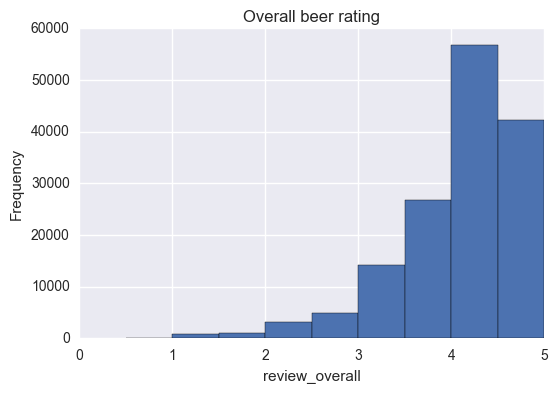

In [10]:
data.review_overall.hist(bins=10)
plt.xlabel("review_overall")
plt.ylabel("Frequency")
plt.title("Overall beer rating");

Using `.unique()` can show the specific rating values:

In [11]:
data.review_overall.unique()

array([ 1.5,  3. ,  4. ,  3.5,  4.5,  5. ,  2. ,  2.5,  1. ,  0. ])

In [12]:
data.review_overall.value_counts().sort_index()

0.0        3
1.0      807
1.5     1054
2.0     3172
2.5     4984
3.0    14216
3.5    26869
4.0    56697
4.5    33237
5.0     8961
Name: review_overall, dtype: int64

Also note that the beer-drinker reviews are not unique, as some people have filed multiple reviews per beer.  We generally take the average rating in such case.

In [13]:
n_reviews = data.groupby(['beer_beerid', 'review_profilename']).review_overall.nunique()
n_reviews.value_counts()

1    147421
2       930
3        13
Name: review_overall, dtype: int64

<hr>
## Content-based filtering

Content-based filtering maps the data into a feature space, in which we can compare beers and drinkers.  Each beer will get a representation in this space (a high alcohol, IPA-like beer from Founders brewery).  Each drinker gets a taste profile (likes high alcohol beers, likes IPAs but dislikes anything from Founders).

Features we will use:
- brewery id
- beer style 
- alcohol percentage (ABV)

We use the brewery as a feature, but it is not sure this is a useful feature, and it might cause overfitting.

### Creating feature matrix (or item profiles)

#### ABV and Brewery ID

We will categorize the ABV feature into bins.

Currently, there are 177 unique values for `beer_abv`:

In [14]:
data.beer_abv.nunique()

177

To categorize the abv values:

1. round off to whole abv values
2. bin values lower or equal to 4 to 4 and values greater than or equal to 10 to 10
3. leave values between 4 and 10 as is
4. convert abv values into strings (to prepare for patsy)

In [15]:
min_bin, max_bin = 4, 10
abv = data.beer_abv.round()

In [16]:
abv[abv <= min_bin] = min_bin

In [17]:
abv[abv >= max_bin] = max_bin

In [18]:
abv.unique()

array([  5.,   6.,   8.,   4.,   7.,  nan,   9.,  10.])

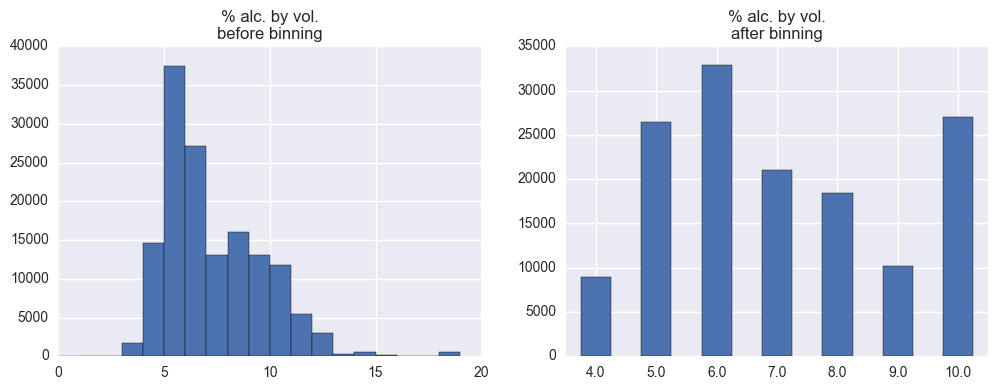

In [19]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
f = data.beer_abv.hist(bins=range(0, 20), ax=axes[0])
axes[0].set_title("% alc. by vol.\nbefore binning")
f = abv.value_counts().sort_index().plot(kind='bar', rot=0, ax=axes[1], title="% alc. by vol.\nafter binning")

We convert numerical values to strings, so patsy will treat them as categorical features

In [20]:
data['beer_abv_cat'] = abv.dropna().astype(int).astype(str)

*** Including `brewery_id` as a feature: ***

In [21]:
data['brewery_id_str'] = data.brewery_id.astype(str)

In [22]:
X_abv_brew = dmatrix('beer_abv_cat + brewery_id_str', data=data.fillna(0), return_type='dataframe')

To learn more about patsy.dmatrix, see http://patsy.readthedocs.io/en/latest/

In [23]:
X_abv_brew.shape

(150000, 596)

In [24]:
X_abv_brew.head()

,Intercept,beer_abv_cat[T.10],beer_abv_cat[T.4],beer_abv_cat[T.5],beer_abv_cat[T.6],beer_abv_cat[T.7],beer_abv_cat[T.8],beer_abv_cat[T.9],brewery_id_str[T.10101],brewery_id_str[T.10103],...,brewery_id_str[T.9483],brewery_id_str[T.954],brewery_id_str[T.9608],brewery_id_str[T.9645],brewery_id_str[T.971],brewery_id_str[T.9729],brewery_id_str[T.9734],brewery_id_str[T.9816],brewery_id_str[T.9827],brewery_id_str[T.9932]
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Beer style

Let's use each word in the beer style as a feature as well (e.g., "IPA")

In [25]:
max_features = 5000
cv = CountVectorizer(max_features=max_features)
X_style = cv.fit_transform(data.beer_style)

In [26]:
X_style

<150000x120 sparse matrix of type '<type 'numpy.int64'>'
	with 416728 stored elements in Compressed Sparse Row format>

In [27]:
X_style.shape

(150000, 120)

##### Putting all the features together to create the feature matrix (item profile)

In [28]:
X = np.hstack([X_abv_brew, X_style.toarray()])
y = data.review_overall
n_samples, n_features = X.shape

Done! Now we have a feature matrix $X$ with ratings in $y$, containing both beers and drinkers.

### Dot-product method

Since the features only describe beer characteristics, each beer entry in $X$ has the same values for the same beer. So we can just take a beer's first occurance for its representation.

In [29]:
uniques, idx = np.unique(data.beer_beerid, return_index=True)
beer_features = pd.DataFrame(X[idx, :], index=data.beer_beerid[idx])
print beer_features.shape
beer_features.head(2)

(6420, 716)


,0,1,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
beer_beerid,,,,,,,,,,,,,,,,,,,,,
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### User profiles

A drinker, however, has different ratings for each beer. Per entry, we will broadcast his or her ratings over the features.

For example,

            low-abv  high-abv  IPA  Stout  Pilsner rating
    beer 1     1        0       0     0       1     2.0
    beer 2     0        1       1     0       0     4.5
    
...will become...

            low-abv  high-abv  IPA  Stout  Pilsner
    beer 1    2.0       0       0     0      2.0
    beer 2     0       4.5     4.5    0       0 
    
... and then we average all ratings per user to get a user profile. We also subtract 3 from each rating, so bad ratings are negative and good ratings positives. This is to compensate for all missing entries, which automoatically get a zero-rating (and are now rated as average, instead of terribly bad).

In [30]:
reviewer_features = pd.DataFrame(X * (data.review_overall.values - 3).reshape(n_samples, 1))

In [31]:
reviewer_features['review_profilename'] = data.review_profilename

In [32]:
reviewer_features.head()

,0,1,2,3,4,5,6,7,8,9,...,707,708,709,710,711,712,713,714,715,review_profilename
0,-1.5,-0.0,-0.0,-1.5,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,stcules
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,stcules
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,stcules
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,stcules
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,johnmichaelsen


In [33]:
reviewer_features = reviewer_features.groupby('review_profilename')[range(n_features)].mean()

In [34]:
reviewer_features = reviewer_features.divide(reviewer_features.sum(axis=1), axis=0)

In [35]:
reviewer_features.head()

,0,1,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.168582,0.080460,0.0,0.000000,0.038314,0.022989,0.030651,-0.003831,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.011494,0.0,0.003831,0.0
05Harley,0.173554,0.074380,0.0,0.000000,0.024793,0.041322,0.016529,0.016529,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.008264,0.000000,0.0,0.000000,0.0
0tt0,0.196429,0.000000,0.0,0.035714,0.000000,0.107143,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
100floods,0.176056,0.084507,0.0,0.000000,0.021127,0.056338,0.014085,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
100proof,0.200000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.200000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


** Start of actual determination of recomendations for a user: **

We now simply take the dot product of the beer vector and the drinker vector.  This means that we will add a user's ratings for each of the beer's features.  

Let's pick an arbitrary user.

In [36]:
user = 'WesWes'

Compute user's vector and all beer vectors, and take dot product.

In [37]:
v = reviewer_features.loc[user].values

In [38]:
M = beer_features.values

In [39]:
pred = M.dot(v)

In [40]:
pred = pd.Series(pred, index=beer_features.index, name="predictions").sort_values(ascending=False, inplace=False)

In [41]:
pred_name = pd.Series(pred.values, beer_names[pred.index], name=pred.name)

In [42]:
print "Top recommendations for {}:".format(user)
print pred_name.head()

Top recommendations for WesWes:
beer_name
Sierra Nevada Pale Ale                  0.409924
Extra Special Pale Ale (ESP)            0.409924
Founders Brassworks Ale                 0.404890
Allocation Ale - Beer Camp #52          0.401654
Sierra Nevada Draught Style Pale Ale    0.401654
Name: predictions, dtype: float64


In [43]:
print "Bottom  recommendations (don't drink these, {}!)".format(user)
print pred_name.tail()

Bottom  recommendations (don't drink these, WesWes!)
beer_name
Europa Schwartz Pils         0.174038
Bald Eagle Kristallweizen    0.174038
Roggenbier                   0.174038
Zwickelbier                  0.174038
Replic Ale (2010)            0.174038
Name: predictions, dtype: float64


How do they compare with his actual reviews?  (Note that we take the mean since multiple reviews per drinker-beer pair occur.)

In [44]:
user_reviews = data[data.review_profilename == user].groupby('beer_beerid').review_overall.mean().sort_values(ascending=False, inplace=False)

In [45]:
user_reviews_name = pd.Series(user_reviews.values, index=beer_names[user_reviews.index])

In [46]:
print "Top reviewed by {}:".format(user)
print user_reviews_name.head()

Top reviewed by WesWes:
beer_name
Black Tuesday                              5.0
Founders KBS (Kentucky Breakfast Stout)    5.0
Northern Hemisphere Harvest Wet Hop Ale    5.0
Stoudt's Double IPA (India Pale Ale)       5.0
Founders CBS Imperial Stout                5.0
dtype: float64


In [47]:
print "Bottom reviewed by {}:".format(user)
print user_reviews_name.tail()

Bottom reviewed by WesWes:
beer_name
Weizen Berry                               3.0
Heineken Premium Light Lager               3.0
Pikop Andropov's Rushin' Imperial Stout    3.0
ESB Amber Ale                              3.0
Organic Münster Alt                        3.0
dtype: float64


Let's compare them all.

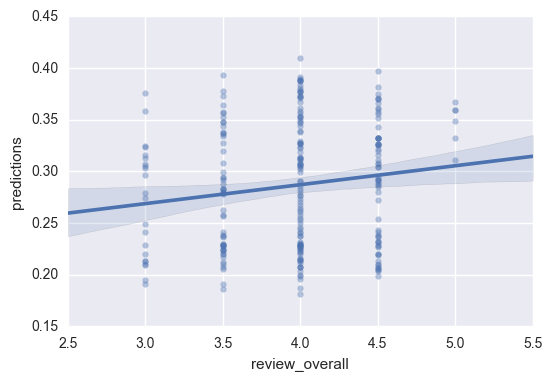

In [48]:
f = sb.regplot(user_reviews, pred[list(user_reviews.index)], scatter_kws=dict(alpha=.4))

Not bad. Note that we completely ignored overfitting and cross validation for readability's sake.

#### Linear Regression

Given this feature matrix and user reviews, we could also use a simple linear regression to predict a review for a user.  We will limit our dataset to the reviews of one user only, and then feed those into the model.

In [49]:
print "Filtering reviews by {}:".format(user)
idx = (data.review_profilename == user).values  # filter reviews of user
X_user, y_user = X[idx, :], y[idx]
print X_user.shape, y_user.shape

Filtering reviews by WesWes:
(253, 716) (253,)


In [50]:
model = Ridge()
model.fit(X_user, y_user)
print cross_val_score(model, X_user, y_user, scoring='neg_mean_absolute_error')
print cross_val_score(model, X_user, y_user, scoring='r2')

[-0.42260271 -0.39218923 -0.38307428]
[-0.22913789 -0.14327301  0.04404437]


Pretty bad cross-validation scores, but mind you we have only a handful reviews.

In [51]:
uniques, idx = np.unique(data.beer_beerid, return_index=True)  # find beer labels
pred = pd.Series(model.predict(X[idx, :]), index=data.beer_beerid[idx], name="predictions") \
    .sort_values(ascending=False, inplace=False)
pred_name = pd.Series(pred.values, beer_names[pred.index], name="predictions")
print "Top recommendations for {}.".format(user)
print pred_name[:5]

Top recommendations for WesWes.
beer_name
Sierra Nevada Imperial Stout                               4.796611
Able I.P.A.                                                4.790692
The Colonel's Porter                                       4.780963
The Colonel's Porter (Cask Primed With English Treacle)    4.780963
Samson                                                     4.752497
Name: predictions, dtype: float64


Let's see how those relate to his actual reviews.

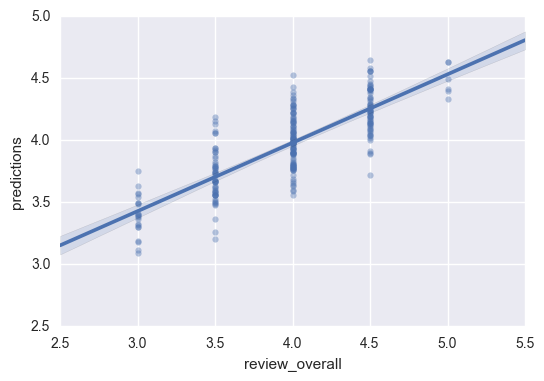

In [52]:
f = sb.regplot(user_reviews, pred[list(user_reviews.index)], scatter_kws=dict(alpha=.4))

Pretty spectacular. 

Just for the fun of it, how will this user rate a random beer?

In [53]:
beer = np.random.choice(beer_names.index)
beer_idx = (data.beer_beerid == beer).values
X_beer = X[beer_idx, :][0]  # just take the first entry
print "{} will give beer {} a rating of {:.1f}.".format(user, beer_names[beer], model.predict(X_beer.reshape(1,-1))[0])

WesWes will give beer D.O.R.I.S. The Destroyer Double Imperial Stout a rating of 4.2.
